# Image Captioning without Visual Attention Mechanics

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

## Import stuff

In [1]:
import sys
#sys.path.append("..")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#download_utils.link_all_keras_resources()

In [4]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend

import zipfile
import json
from collections import defaultdict

# from random import choice
import os
from keras_utils import reset_tf_session
import tqdm_utils

Using TensorFlow backend.


In [48]:
import utils
import re
import random
import time

## Extract captions for images

In [ ]:
# TODO: Add filter for jpg files!!!

In [6]:
names = os.listdir('train2014/')
train_img_fns = [x[:len(x)-4] for x in names]
train_img_fns[:10]

['COCO_train2014_000000000009.jpg',
 'COCO_train2014_000000000025.jpg',
 'COCO_train2014_000000000030.jpg',
 'COCO_train2014_000000000034.jpg',
 'COCO_train2014_000000000036.jpg',
 'COCO_train2014_000000000049.jpg',
 'COCO_train2014_000000000061.jpg',
 'COCO_train2014_000000000064.jpg',
 'COCO_train2014_000000000071.jpg',
 'COCO_train2014_000000000072.jpg']

In [7]:
names = os.listdir('val2014/')
val_img_fns = [x[:len(x)-4] for x in names]
val_img_fns[:10]

['COCO_val2014_000000000042.jpg',
 'COCO_val2014_000000000073.jpg',
 'COCO_val2014_000000000074.jpg',
 'COCO_val2014_000000000133.jpg',
 'COCO_val2014_000000000136.jpg',
 'COCO_val2014_000000000139.jpg',
 'COCO_val2014_000000000143.jpg',
 'COCO_val2014_000000000164.jpg',
 'COCO_val2014_000000000192.jpg',
 'COCO_val2014_000000000196.jpg']

In [8]:
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

print(len(train_captions), len(train_img_fns))
print(len(val_captions), len(val_img_fns))

82783 82783
40504 40504


In [9]:
train_captions[:2]

[['Closeup of bins of food that include broccoli and bread.',
  'A meal is presented in brightly colored plastic trays.',
  'there are containers filled with different kinds of foods',
  'Colorful dishes holding meat, vegetables, fruit, and bread.',
  'A bunch of trays that have different food.'],
 ['A giraffe eating food from the top of the tree.',
  'A giraffe standing up nearby a tree ',
  'A giraffe mother with its baby in the forest.',
  'Two giraffes standing in a tree filled area.',
  'A giraffe standing next to a forest filled with trees.']]

In [10]:
val_captions[:2]

[['This wire metal rack holds several pairs of shoes and sandals',
  'A dog sleeping on a show rack in the shoes.',
  'Various slides and other footwear rest in a metal basket outdoors.',
  'A small dog is curled up on top of the shoes',
  'a shoe rack with some shoes and a dog sleeping on them'],
 ['A motorcycle parked in a parking space next to another motorcycle.',
  'An old motorcycle parked beside other motorcycles with a brown leather seat.',
  'Motorcycle parked in the parking lot of asphalt.',
  'A close up view of a motorized bicycle, sitting in a rack. ',
  'The back tire of an old style motorcycle is resting in a metal stand. ']]

In [11]:
# # load prepared embeddings
# train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
# train_img_fns = utils.read_pickle("train_img_fns.pickle")
# val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
# val_img_fns = utils.read_pickle("val_img_fns.pickle")
# # check shapes
# print(train_img_embeds.shape, len(train_img_fns))
# print(val_img_embeds.shape, len(val_img_fns))

## Preprocess captions for images

In [ ]:
# TODO: Add to DataLoader code for sampling

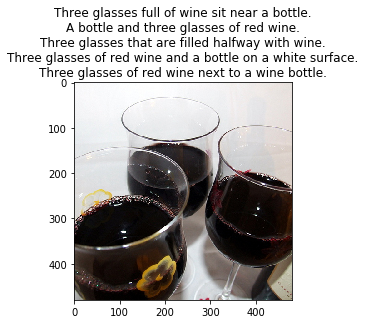

In [12]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, 140)

## Prepare captions for training

In [13]:
# preview captions data
train_captions[:2]

[['Closeup of bins of food that include broccoli and bread.',
  'A meal is presented in brightly colored plastic trays.',
  'there are containers filled with different kinds of foods',
  'Colorful dishes holding meat, vegetables, fruit, and bread.',
  'A bunch of trays that have different food.'],
 ['A giraffe eating food from the top of the tree.',
  'A giraffe standing up nearby a tree ',
  'A giraffe mother with its baby in the forest.',
  'Two giraffes standing in a tree filled area.',
  'A giraffe standing next to a forest filled with trees.']]

In [14]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

In [15]:
def generate_vocabulary(train_captions):

    ### khmelkoff:
    
    adds = [PAD, UNK, START, END]
    
    vocab = [split_sentence(y) for x in train_captions for y in x]
    vocab = [y for x in vocab for y in x] # flatten
    
    values, counts = np.unique(vocab, return_counts=True)
    vocab = values[counts >= 5]
    vocab = list(vocab)
    vocab.extend(adds)
    
    return {token: index for index, token in enumerate(sorted(vocab))}

In [16]:
def caption_tokens_to_indices(captions, vocab):

    ### khmelkoff:
    
    res = [[split_sentence(y) for y in x] for x in captions]
    _ = [[x.insert(0,START) for x in z] for z in res]
    _ = [[x.append(END) for x in z] for z in res]
    res = [[[vocab.get(y,vocab[UNK]) for y in x] for x in z] for z in res]
    
    return res

In [17]:
%%time
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769
Wall time: 8.09 s


In [18]:
%%time
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

Wall time: 11 s


In [19]:
vocab[UNK]

3

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an equal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [20]:
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):

    ### khmelkoff:
    
    if max_len==None:
        columns = max(map(len, batch_captions))
        max_len = columns
    else:
        columns = min(max_len, max(map(len, batch_captions)))
    

    matrix = np.zeros([len(batch_captions), columns], dtype=int) + pad_idx

    for i in range(len(batch_captions)):
        row = batch_captions[i]
        matrix[i,:len(row)] = row[:columns]
    
    return matrix

In [21]:
# make sure you use correct argument in caption_tokens_to_indices
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

## Training

### Define architecture

In [22]:
#img_features = np.load(img_name.decode('utf-8')+'.npy')
img_features = np.load('./train2014/'+train_img_fns[0]+'.npy')

In [23]:
img_features

array([0.2463532 , 0.35691983, 0.7924731 , ..., 0.1454285 , 0.42524502,
       0.5842788 ], dtype=float32)

In [24]:
img_features.shape

(2048,)

In [25]:
IMG_EMBED_SIZE = img_features.shape[0]
WORD_EMBED_SIZE = 150
LSTM_UNITS = 512
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [26]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

In [27]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # reduce the number of parameters
    # image embedding -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_SIZE),
                                         activation='elu')

    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    

    ### khmelkoff:
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embeds)

    # embed all tokens but the last for lstm input,
    # try to use tf's style slicing ;)
    word_embeds = word_embed(tf.slice(sentences, [0,0], [tf.shape(sentences)[0], 
                                                         tf.shape(sentences)[1]-1]))
    

    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS])

    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(tf.slice(sentences, [0,1], [tf.shape(sentences)[0], 
                                                               tf.shape(sentences)[1]-1]), [-1])

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx)

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!

    loss = tf.reduce_mean(tf.boolean_mask(xent,  flat_loss_mask))

In [28]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [29]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [30]:
vocab[PAD]

1

In [31]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(dirname, fns, indexed_captions, batch_size, max_len=None):

    ### khmelkoff:
    
    batch_index = np.random.choice(len(fns), batch_size, replace=False)
    caption_index = np.random.choice(range(5), batch_size)
    
    batch_image_embeddings = []
    for idx in batch_index:
        batch_image_embeddings.append(np.load(dirname + fns[idx] + '.npy'))
    
    batch_captions = indexed_captions[batch_index]
    batch_captions = [x[y] for x, y in zip(batch_captions, caption_index)]

    batch_captions_matrix = batch_captions_to_matrix(batch_captions, 1, max_len=None)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [32]:
batch_size = 64
n_epochs = 20
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [33]:
# you can load trained weights here
# you can load "weights_{epoch}" and continue training
# uncomment the next line if you need to load weights
# saver.restore(s, os.path.abspath("weights"))

Look at the training and validation loss, they should be decreasing!

In [34]:
# actual training loop
MAX_LEN = 30  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch('./train2014/', train_img_fns,
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch('./val2014/', val_img_fns,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, os.path.abspath("weights_{}".format(epoch)))
    
print("Finished!")


Epoch: 0, train loss: 4.199528639793396, val loss: 3.4929067063331605



Epoch: 1, train loss: 3.231122375965118, val loss: 3.104650247097015



Epoch: 2, train loss: 2.9886212425231933, val loss: 2.9370632672309878



Epoch: 3, train loss: 2.843693231344223, val loss: 2.8558206033706663



Epoch: 4, train loss: 2.7660602378845214, val loss: 2.772000463008881



Epoch: 5, train loss: 2.691534907579422, val loss: 2.713616306781769



Epoch: 6, train loss: 2.649313576698303, val loss: 2.696936252117157



Epoch: 7, train loss: 2.6029158747196197, val loss: 2.6725139904022215



Epoch: 8, train loss: 2.568577441215515, val loss: 2.6482044529914854



Epoch: 9, train loss: 2.531863939523697, val loss: 2.634184913635254



Epoch: 10, train loss: 2.515341841459274, val loss: 2.5955938339233398



Epoch: 11, train loss: 2.4921180403232572, val loss: 2.6162493133544924



Epoch: 12, train loss: 2.4710478727817535, val loss: 2.591655478477478



Epoch: 13, train loss: 2.4491111268997194, val loss: 2.5802087378501892



Epoch: 14, train loss: 2.428566618204117, val loss: 2.5576381731033324



Epoch: 15, train loss: 2.42058735370636, val loss: 2.529760890007019



Epoch: 16, train loss: 2.4084209825992584, val loss: 2.5546572375297547



Epoch: 17, train loss: 2.388051247596741, val loss: 2.525935182571411



Epoch: 18, train loss: 2.37942138838768, val loss: 2.510842225551605



Epoch: 19, train loss: 2.3655184009075163, val loss: 2.5114536809921266
Finished!


In [35]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch('./train2014/', train_img_fns,
                                           train_captions_indexed, 
                                           batch_size
                                           )
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.6207528
Accuracy: 0.44517833553500663
Example 0
Predicted: a cat bear is sitting in a car #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a stuffed horse is folded into a suitcase #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a baseball baseball player swinging to hit a ball #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a professional baseball player attempting to hit the ball #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a man holding a red shirt holding holding a tennis racket #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a man in a red truck is holding a tennis racket #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#



In [36]:
# save graph weights to file!
saver.save(s, os.path.abspath("weights"))

'C:\\Users\\khmelkov\\Documents\\Git\\ImageCaptioning\\weights'

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [40]:
IMG_SIZE = 299
# take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

In [41]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, os.path.abspath("weights"))  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(img_embeds) ## corrected
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from C:\Users\khmelkov\Documents\Git\ImageCaptioning\weights


In [42]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.9999999997962965 2.0370359759195462e-10 1.2676505999700117e-70 with temperature 0.01
0.9030370433250645 0.09696286420394223 9.247099323648666e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.35344772639219624 0.34564811360592396 0.3009041600018798 with temperature 10
0.33536728048099185 0.33461976434857876 0.3300129551704294 with temperature 100


In [43]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

#### Translation

In [44]:
from googletrans import Translator
translator = Translator()
# translator.translate('morning glory', src='en', dest='ru')

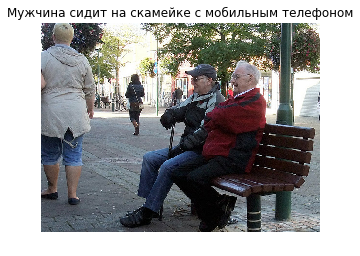

In [46]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(5, 5))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    cap = generate_caption(img)[1:-1]
    text = ' '.join(cap)
    ru_cap = translator.translate(text, src='en', dest='ru').text
    first_letter = ru_cap[0]
    ru_cap = first_letter.upper() + ru_cap[1:]
    # print(ru_cap)
    plt.title(ru_cap)
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=101)

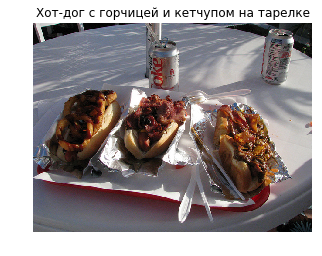

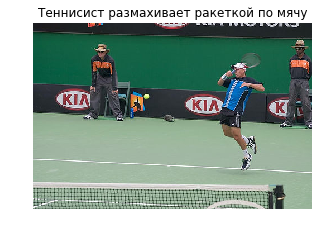

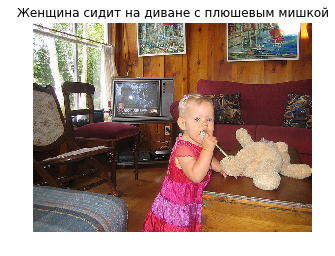

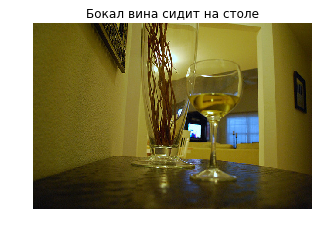

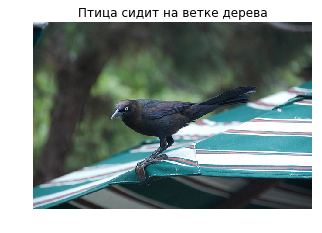

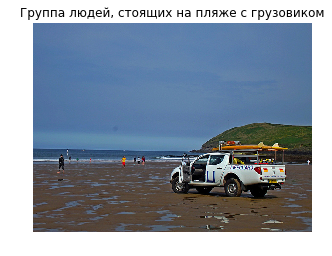

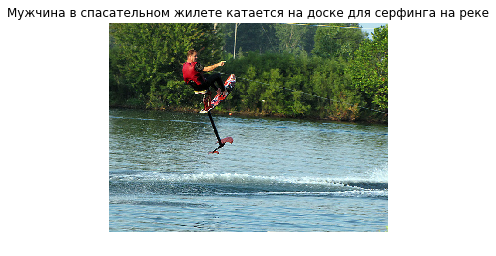

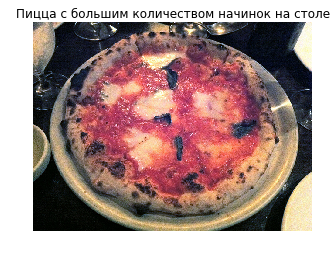

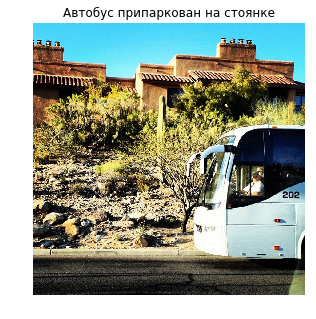

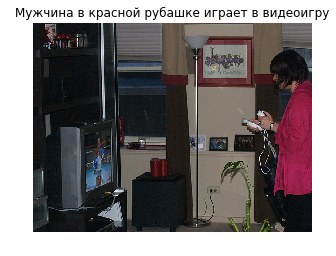

In [49]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10, replace=False):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)